## Transformers as Feature Extractors
Freeze the pre-trained parameters, use the hidden states as features and train a classifier on them.  
Advantage: quickly train a small or shallow model, low/no GPU comsumption.

In [1]:
import os, torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [4]:
model_ckpt = "distilbert-base-uncased"
model = AutoModel.from_pretrained(model_ckpt).to(device)
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [5]:
# Load and tokenize the dataset
emotions = load_dataset('emotion')

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded

/mount/studenten/arbeitsdaten-studenten1/shencg/condaenvs/nlp-with-transformers/lib/python3.11/site-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

### Extract the last hidden states

In [6]:
text = "the Giza pyramid complex"
inputs = tokenizer(text, return_tensors="pt")
print(inputs)
print(f"Input tensor shape: {inputs['input_ids'].size()}")

{'input_ids': tensor([[  101,  1996, 21025,  4143, 11918,  3375,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}
Input tensor shape: torch.Size([1, 7])


shape: [batch_size, n_tokens]

In [7]:
# Place the encodings on the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}
inputs

{'input_ids': tensor([[  101,  1996, 21025,  4143, 11918,  3375,   102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [8]:
# Disable the automatic calculation of the gradients --> reduce the memory footprint of the computations --> useful for inference
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.2782,  0.1296, -0.5134,  ..., -0.3248,  0.2311,  0.3518],
         [-0.2287,  0.5525, -1.0616,  ..., -0.4091,  0.5197, -0.0232],
         [-0.0368, -0.0113, -0.1147,  ..., -1.0068,  0.2950,  0.0134],
         ...,
         [ 0.7177,  0.6947, -0.7928,  ..., -0.5803,  0.2743, -0.0529],
         [ 0.5455,  0.4894, -0.5843,  ..., -0.5104, -0.1475,  0.0071],
         [ 0.7916,  0.2064, -0.3990,  ...,  0.0375, -0.6979, -0.1885]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [9]:
outputs.last_hidden_state.size()

torch.Size([1, 7, 768])

The last hidden state has the shape [batch_size, n_tokens, hidden_dim].  
A 768-dimensional vector is returned for each of the 6 input tokens.  
Common practice for classification task: use the hidden state associated with the [CLS] token as the input feature.

In [10]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [11]:
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [12]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [13]:
pd.DataFrame(emotions_encoded['test'])

,label,input_ids,attention_mask
0,tensor(0),"[tensor(101), tensor(10047), tensor(3110), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,tensor(0),"[tensor(101), tensor(10047), tensor(2039), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,tensor(0),"[tensor(101), tensor(1045), tensor(2196), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
3,tensor(1),"[tensor(101), tensor(1045), tensor(2187), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,tensor(0),"[tensor(101), tensor(1045), tensor(2001), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
...,...,...,...
1995,tensor(3),"[tensor(101), tensor(1045), tensor(2074), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1996,tensor(3),"[tensor(101), tensor(10047), tensor(3110), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1997,tensor(1),"[tensor(101), tensor(1045), tensor(2514), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1998,tensor(1),"[tensor(101), tensor(10047), tensor(3110), ten...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [14]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [15]:
emotions_hidden['test'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [16]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
print(X_train.shape, X_valid.shape)

(16000, 768) (2000, 768)


In [17]:
# Scale features to the range [0, 1]
X_scaled = MinMaxScaler().fit_transform(X_train)
X_scaled

array([[0.36425358, 0.58609855, 0.39730024, ..., 0.74592835, 0.50480545,
        0.6927476 ],
       [0.4534639 , 0.45611888, 0.33501142, ..., 0.539718  , 0.5051363 ,
        0.6042194 ],
       [0.5296936 , 0.6890424 , 0.6535349 , ..., 0.59325606, 0.488886  ,
        0.68543804],
       ...,
       [0.48408335, 0.39301938, 0.57452935, ..., 0.6562952 , 0.39327252,
        0.6084523 ],
       [0.5580843 , 0.66035223, 0.64099705, ..., 0.7481152 , 0.43671045,
        0.7488059 ],
       [0.50531745, 0.58877933, 0.5125651 , ..., 0.63667023, 0.49530464,
        0.5319329 ]], dtype=float32)

Reduce the dimensionality of the hidden states to 2D using UMAP for efficient visualization.  
https://github.com/lmcinnes/umap

In [18]:
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
mapper

UMAP(angular_rp_forest=True, metric='cosine', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [19]:
mapper.__dict__

{'n_neighbors': 15,
 'metric': 'cosine',
 'output_metric': 'euclidean',
 'target_metric': 'categorical',
 'metric_kwds': None,
 'output_metric_kwds': None,
 'n_epochs': None,
 'init': 'spectral',
 'n_components': 2,
 'repulsion_strength': 1.0,
 'learning_rate': 1.0,
 'spread': 1.0,
 'min_dist': 0.1,
 'low_memory': True,
 'set_op_mix_ratio': 1.0,
 'local_connectivity': 1.0,
 'negative_sample_rate': 5,
 'random_state': None,
 'angular_rp_forest': True,
 'transform_queue_size': 4.0,
 'target_n_neighbors': -1,
 'target_metric_kwds': None,
 'target_weight': 0.5,
 'transform_seed': 42,
 'transform_mode': 'embedding',
 'force_approximation_algorithm': False,
 'verbose': False,
 'tqdm_kwds': {'desc': 'Epochs completed',
  'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]',
  'disable': True},
 'unique': False,
 'densmap': False,
 'dens_lambda': 2.0,
 'dens_frac': 0.3,
 'dens_var_shift': 0.1,
 'output_dens': False,
 'disconnection_distance': None,
 'precomputed_kn

In [20]:
mapper.embedding_

array([[ 4.2588873,  6.6313148],
       [-3.0689275,  5.626135 ],
       [ 5.2788177,  3.3010712],
       ...,
       [-2.3520446,  3.113843 ],
       [ 5.1717787,  3.5098925],
       [-1.8670554,  5.59978  ]], dtype=float32)

In [21]:
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb

,X,Y,label
0,4.258887,6.631315,0
1,-3.068928,5.626135,0
2,5.278818,3.301071,3
3,-2.145915,3.617898,2
4,-3.182133,3.701628,3
...,...,...,...
15995,-0.596645,6.938732,0
15996,-2.357928,5.516529,0
15997,-2.352045,3.113843,1
15998,5.171779,3.509892,3


labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


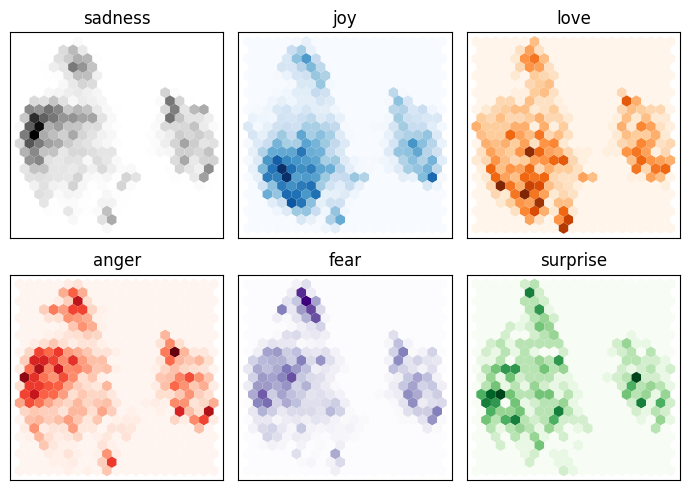

In [22]:
# Plot the density of points for each category

fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names
print('labels:', labels)

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(
        df_emb_sub['X'], 
        df_emb_sub['Y'],
        cmap=cmap,
        gridsize=20,
        linewidths=(0,)
        )
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

Observations:  
- Negative emotions (“sadness”, “anger”, “fear”) all occupy similar regions with slightly different distributions.
- Positive emotions (“joy”, “love”) are well separated from the negative ones.
- The neutral emotion “surprise” is scattered all over the place.

Train a logistic regression classifier using the features

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
# Increase 'max_iter' to guarantee convergence
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

DummyClassifier can be used to build baseline models using simple heuristics, e.g. majority vote or random sampling.  
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [25]:
from sklearn.dummy import DummyClassifier

In [26]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(7, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

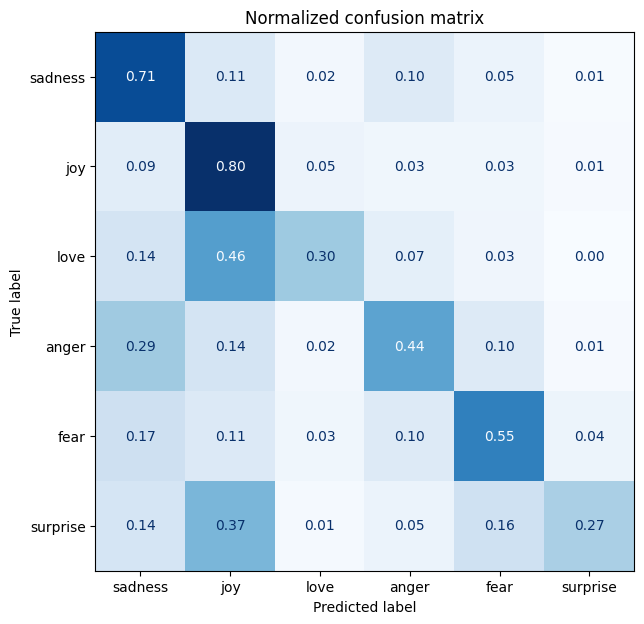

In [28]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-tuning Transformers
Train the whole model end-to-end, which updates the parameters of the pre-trained model.  
Advantage: far better performance.

In [29]:
from transformers import AutoModelForSequenceClassification

In [31]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, 
    num_labels=num_labels
    ).to(device)
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

num_labels:  
https://stackoverflow.com/questions/71768061/huggingface-transformers-classification-using-num-labels-1-vs-2

In [32]:
from sklearn.metrics import accuracy_score, f1_score

transformers.EvalPrediction:  
https://huggingface.co/docs/transformers/internal/trainer_utils#transformers.EvalPrediction

In [37]:
from transformers import EvalPrediction

def compute_metrics(pred: EvalPrediction):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1
    }

In [34]:
# from huggingface_hub import notebook_login
# notebook_login()

In [35]:
from transformers import Trainer, TrainingArguments

In [36]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level='error'
)

In [38]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    compute_metrics=compute_metrics
)

/mount/studenten/arbeitsdaten-studenten1/shencg/condaenvs/nlp-with-transformers/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.771100,0.246391,0.918000,0.918162
2,0.196700,0.166639,0.934000,0.933985
3,0.133900,0.160109,0.934000,0.934600
4,0.105000,0.142202,0.939000,0.938896
5,0.088800,0.140216,0.939000,0.938917


TrainOutput(global_step=1250, training_loss=0.25912655181884764, metrics={'train_runtime': 471.4577, 'train_samples_per_second': 169.686, 'train_steps_per_second': 2.651, 'total_flos': 1800857154240000.0, 'train_loss': 0.25912655181884764, 'epoch': 5.0})

In [40]:
preds_output = trainer.predict(emotions_encoded['validation'])
preds_output

PredictionOutput(predictions=array([[ 5.4415817 , -1.8921696 , -1.7608764 , -2.3341188 , -1.9009081 ,
        -2.3963404 ],
       [ 5.54924   , -2.0001972 , -2.3504431 , -1.8602148 , -1.7049522 ,
        -2.3531797 ],
       [-2.048728  ,  3.1768873 ,  3.1674898 , -2.2897234 , -2.8224707 ,
        -2.5913193 ],
       ...,
       [-1.9747071 ,  5.8503985 , -0.96709734, -1.7784573 , -2.2898455 ,
        -1.9252975 ],
       [-2.4857328 ,  3.9664903 ,  2.6237738 , -2.5346868 , -2.9093935 ,
        -2.187137  ],
       [-2.244568  ,  5.8357835 , -1.152442  , -2.0848494 , -2.0859609 ,
        -1.2098219 ]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.14021621644496918, 'test_accuracy': 0.939, 'test_f1': 0.93891670326451, 'test_runtime': 1.3689, 'test_samples_per_second': 1461.023, 'test_steps_per_second': 23.376})

In [44]:
preds_output.metrics

{'test_loss': 0.14021621644496918,
 'test_accuracy': 0.939,
 'test_f1': 0.93891670326451,
 'test_runtime': 1.3689,
 'test_samples_per_second': 1461.023,
 'test_steps_per_second': 23.376}

In [45]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_preds

array([0, 0, 1, ..., 1, 1, 1])

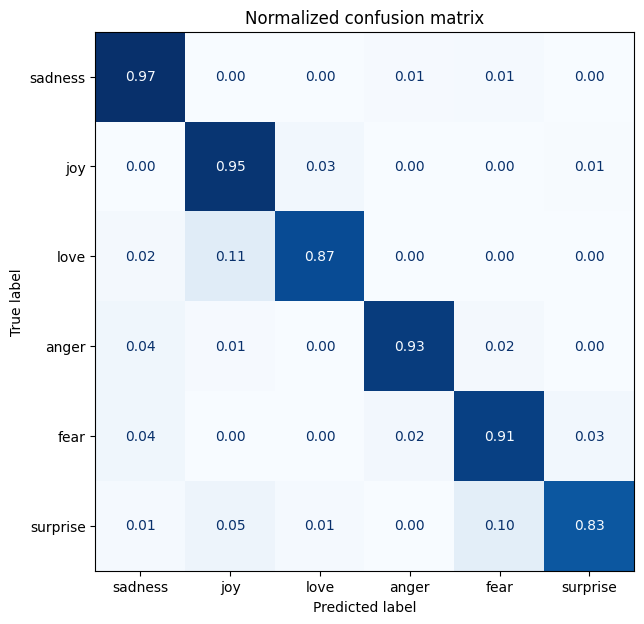

In [46]:
plot_confusion_matrix(y_preds, y_valid, labels)

## Error Analysis
Sort the validation samples by the model loss.

In [47]:
from torch.nn.functional import cross_entropy

When passing the label during the forward pass, the loss is automatically calculated and returned.

In [56]:
def forward_pass_with_label(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits, axis=-1)
        loss = cross_entropy(outputs.logits, batch['label'].to(device), reduction='none')
    return {
        'loss': loss.cpu().numpy(),
        'predicted_label': pred_label.cpu().numpy()
    }

In [58]:
# Convert the dataset back to PyTorch tensors
emotions_encoded.set_format(
    'torch', 
    columns=['input_ids', 'attention_mask', 'label']
    )

# Compute loss values
emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_label, batched=True, batch_size=16)

def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

# Create a DataFrame with the texts, losses, and predicted/true labels
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [59]:
df_test

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.002856
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.002576
2,i feel like a faithful servant,love,joy,0.705469
3,i am just feeling cranky and blue,anger,anger,0.005146
4,i can have for a treat or if i am feeling festive,joy,joy,0.002769
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,sadness,0.004543
1996,i constantly worry about their fight against n...,joy,joy,0.002859
1997,i feel its important to share this info for th...,joy,joy,0.002688
1998,i truly feel that if you are passionate enough...,joy,joy,0.236946


In [60]:
df_test.sort_values('loss', ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,7.871295
1111,im lazy my characters fall into categories of ...,joy,fear,6.819825
1801,i feel that he was being overshadowed by the s...,love,sadness,6.370563
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.742995
882,i feel badly about reneging on my commitment t...,love,sadness,5.676443
1963,i called myself pro life and voted for perry w...,joy,sadness,5.370152
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.332548
188,i was going to tell you more about my trip to ...,sadness,joy,4.092857
1870,i guess i feel betrayed because i admired him ...,joy,love,3.834183
1919,i should admit when consuming alcohol myself i...,fear,sadness,3.778509


In [62]:
df_test.sort_values('loss', ascending=True).head(10)

,text,label,predicted_label,loss
11,i was dribbling on mums coffee table looking o...,joy,joy,0.002163
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.002221
1873,i feel practically virtuous this month i have ...,joy,joy,0.002224
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.002234
1310,i feel like an ungrateful asshole,sadness,sadness,0.002253
877,im caught up on sleep and no longer feel like ...,joy,joy,0.002260
400,i are just relaxing together and i feel ecstat...,joy,joy,0.002271
212,i own the brushes are constantly used and i fe...,joy,joy,0.002274
1607,i feel incredibly mellow and spacey,joy,joy,0.002279
1094,i did find myself wondering just how her stepc...,joy,joy,0.002279
